In [95]:
#from IPython.display import display, HTML
#display(HTML("<style>.container { width:100% ! important; }<style>"))

In [96]:
import sys
import pyvisa as visa
import time
import struct
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [97]:
#connect to scope
try:
    SCOPE_VISA_ADDRESS = 'USB0::0x0957::0x1790::MY58031279::0::INSTR' #VISA address goes here, can be obtained from 
    # IO Libraries Connection Expert or by using the scope panel: utilities -> configure LAN -> USB VISA Address 
    rm = visa.ResourceManager()
    scope = rm.open_resource(SCOPE_VISA_ADDRESS)
    print("Connection to " + scope.query('*IDN?') + " successfull.")
    
except Exception:
    print("Unable to connect to oscilloscope at " + str(SCOPE_VISA_ADDRESS) + ". Aborting script.")
    sys.exit()

Connection to AGILENT TECHNOLOGIES,MSO-X 6004A,MY58031279,07.30.2019051434
 successfull.


In [98]:
# establish number of points and time out
USER_REQUESTED_POINTS = 1000
GLOBAL_TOUT =  10000 # IO time out in milliseconds

In [99]:
## Save Locations
BASE_FILE_NAME = "my_data"
BASE_DIRECTORY = "C:\\Users\\Public\\"
    ## IMPORTANT NOTE:  This script WILL overwrite previously saved files!

In [100]:
#connect to visa library that contains code and data that can be used by more than one program at the same time
rm = visa.ResourceManager('visa32.dll') # this uses PyVisa
## This directory will need to be changed if VISA was installed somewhere else.
# it is generally not needed to call it explicitly: rm = visa.ResourceManager()

In [101]:
# Clear the status data structures, the device-defined error queue, and the Request-for-OPC flag
scope.clear()
## DO NOT RESET THE SCOPE! - since that would wipe out data...
scope.write("*CLS")
## Data should already be acquired and scope should be STOPPED (Run/Stop button is red).

6

In [102]:
## Determine Which channels are on AND have acquired data - Scope should have already acquired data and be in a stopped 
# state (Run/Stop button is red).

## Get Number of analog channels on scope
IDN = str(scope.query("*IDN?"))
IDN = IDN.split(',') # IDN parts are separated by commas, so parse on the commas
MODEL = IDN[1]
NUMBER_ANALOG_CHS = int(MODEL[len(MODEL)-2])
print("There are " + str(NUMBER_ANALOG_CHS) + " analog channels on this device.")

There are 4 analog channels on this device.


In [103]:
# choose which channels to display and obtain data from
# must do this manually since noise triggers the channel to be displayed

for ch in range(1, NUMBER_ANALOG_CHS+1):
    scope.write(":BLANk CHANnel" + str(ch)) #blank channels
    scope.write(":CHANnel1:DISPlay OFF") #choose ON or OFF as desired
    scope.write(":CHANnel2:DISPlay ON")
    scope.write(":CHANnel3:DISPlay OFF")
    scope.write(":CHANnel4:DISPlay OFF")
    On_Off = int(scope.query(":CHANnel" + str(ch) + ":DISPlay?")) # checks if the channel is displayed by returning a 1 or 0
    if On_Off == 1:
        print("channel " + str(i+1) + " is on")
        print("The amplitud is " + str(scope.query(":MEASure:VTOP? CHANnel" + str(ch))).strip('\n') + scope.query(":CHANnel" + str(ch) + ":UNITs?"))
        #amplitud useful for double checking with the screen
    else:
        print("channel " + str(i+1) + " is off")

channel 4 is off
channel 4 is on
The amplitud is +99E+36VOLT

channel 4 is off
channel 4 is off


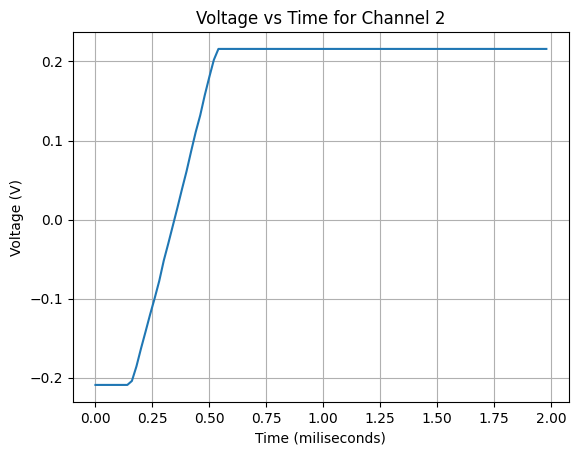

In [104]:
def voltage_vs_time(ch):
    try:
        scope.write('*CLS')

        scope.write(":ACQuire:TYPE HRESolution")
        # sets the oscilloscope in the high-resolution mode (also known as smoothing). 
        # This mode is used to reduce noise at slower sweep speeds where the digitizer samples faster than needed to fill 
        # memory for the displayed time range. The slower the sweep speed, the greater the number of samples
        # that are averaged together for each display point.
        
        # if prefered use scope.write(":ACQuire:NORMal") instead
        
        scope.write(":TIMebase:MODE MAIN")
        scope.write(":WAVeform:SOURce CHANnel{}".format(ch))
        scope.write(":WAVeform:FORMat WORD")
        scope.write(":WAVeform:POINts 100")

        scope.write(":SINGle")
        #causes the instrument to acquire a single trigger of data.
        #This is the same as pressing the Single key on the front panel.
        
        preamble = scope.query(":WAVeform:PREamble?").split(",")
        values = scope.query_binary_values(":WAVeform:DATA?", datatype="h", container=np.array)
        

        num_samples = int(preamble[2])


        x_increment = float(preamble[4])
        x_origin = 0 #set as desired or use float(preamble[5])
        x_reference = float(preamble[6])
        time = np.array([(np.arange(num_samples)-x_reference)*x_increment + x_origin])
        time = time.T # make x values vertical
        time_in_miliseconds = time * 1e3
        
        y_increment = float(preamble[7])
        y_origin = float(preamble[8])
        y_reference = float(preamble[9])
        voltage = (values-y_reference)*y_increment + y_origin
        
        return time_in_miliseconds, voltage
        
    except Exception as e:
        print(e)
    
    
for ch in range(1,NUMBER_ANALOG_CHS+1):
    On_Off = int(scope.query(":CHANnel" + str(ch) + ":DISPlay?")) # checks if the channel is displayed by returning a 1 or 0
    if On_Off == 1:
        t, v = voltage_vs_time(ch)
        plt.plot(t, v)
        plt.title("Voltage vs Time for Channel " + str(ch))
        plt.xlabel('Time (miliseconds)')
        plt.ylabel('Voltage (V)')
        plt.grid()
        plt.ylim()
        plt.show()

In [105]:
scope.write('*CLS')

scope.write(":ACQuire:TYPE HRESolution")
# sets the oscilloscope in the high-resolution mode (also known as smoothing). 
# This mode is used to reduce noise at slower sweep speeds where the digitizer samples faster than needed to fill 
# memory for the displayed time range. The slower the sweep speed, the greater the number of samples
# that are averaged together for each display point.

# if prefered use scope.write(":ACQuire:NORMal") instead

scope.write(":TIMebase:MODE MAIN")
scope.write(":WAVeform:SOURce CHANnel{}".format(ch))
scope.write(":WAVeform:FORMat WORD")
scope.write(":WAVeform:POINts 100")

scope.write(":SINGle")
#causes the instrument to acquire a single trigger of data.
#This is the same as pressing the Single key on the front panel.

preamble = scope.query(":WAVeform:PREamble?").split(",")
values = scope.query_binary_values(":WAVeform:DATA?", datatype="h", container=np.array)


num_samples = int(preamble[2])


x_increment = float(preamble[4])
x_origin = 0 #set as desired or use float(preamble[5])
x_reference = float(preamble[6])
time = np.array([(np.arange(num_samples)-x_reference)*x_increment + x_origin])
time = time.T # make x values vertical
time_in_miliseconds = time * 1e3

y_increment = float(preamble[7])
y_origin = float(preamble[8])
y_reference = float(preamble[9])
voltage = (values-y_reference)*y_increment + y_origin

np.save('wav_time.npy', np.array((time_in_miliseconds)).T)
print("The time values in miliseconds have been saved to wav_time.npy")
time_data = np.load('wav_time.npy')
print(time_data)

np.save("wav_voltage.npy", np.array((voltage)))
print('The voltage values in VOLTS have been saved to wav_voltage.npy')
voltage_data = np.load('wav_voltage.npy')
print(voltage_data)


The time values in miliseconds have been saved to wav_time.npy
[[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
  0.28 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54
  0.56 0.58 0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82
  0.84 0.86 0.88 0.9  0.92 0.94 0.96 0.98 1.   1.02 1.04 1.06 1.08 1.1
  1.12 1.14 1.16 1.18 1.2  1.22 1.24 1.26 1.28 1.3  1.32 1.34 1.36 1.38
  1.4  1.42 1.44 1.46 1.48 1.5  1.52 1.54 1.56 1.58 1.6  1.62 1.64 1.66
  1.68 1.7  1.72 1.74 1.76 1.78 1.8  1.82 1.84 1.86 1.88 1.9  1.92 1.94
  1.96 1.98]]
The voltage values in VOLTS have been saved to wav_voltage.npy
[ 0.12552301  0.08368201  0.12552301  0.12552301  0.12552301  0.25104603
  0.20920502 -0.041841    0.041841    0.041841    0.16736402  0.041841
  0.20920502  0.041841    0.12552301  0.12552301  0.041841    0.
  0.12552301  0.16736402  0.12552301  0.08368201  0.041841    0.041841
  0.041841    0.08368201  0.08368201  0.08368201  0.08368201 -0.041841
  0.08

In [108]:
#save to csv file

for ch in range(1, NUMBER_ANALOG_CHS+1):
    On_Off = int(scope.query(":CHANnel" + str(ch) + ":DISPlay?")) # checks if the channel is displayed by returning a 1 or 0
    if On_Off == 1:
        import csv
        data = []
        for i in range((x_origin)):
            row = [x_origin[i], y_origin[i]]
            data.append(row)
            # Define the CSV file name
            file_name = BASE_DIRECTORY + BASE_FILE_NAME + "_channel{}.csv".format(ch)

            # Save the data to CSV
            with open(file_name, 'w', newline='') as file:
                writer = csv.writer(file)
                writer.writerow(['Time (s)', 'Voltage (V)'])
                writer.writerows(data)

        print("Data saved to CSV file: ", file_name)

Data saved to CSV file:  C:\Users\Public\my_data_channel4.csv
Data saved to CSV file:  C:\Users\Public\my_data_channel4.csv
